In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt


%matplotlib inline

In [2]:
#load the GEF2012 data and labels
from load_GEF2012 import load_GEF2012
data, labels = load_GEF2012()

In [3]:
#further process the data and labels
from process_GEF2012 import process_GEF2012
data_labels_set = process_GEF2012(data,labels)

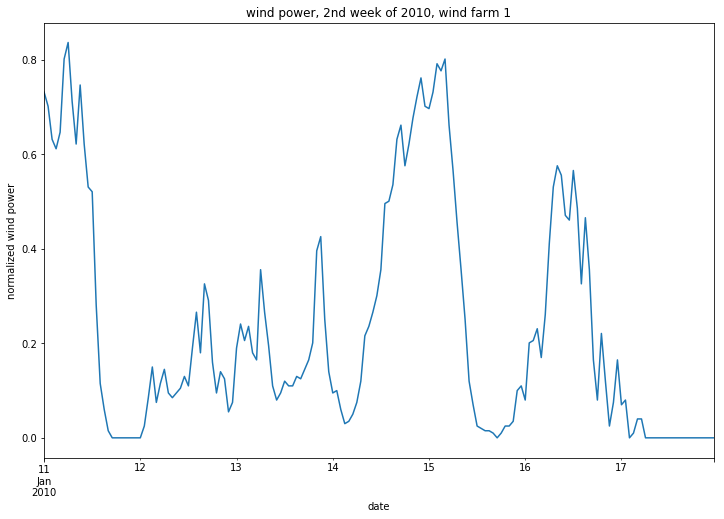

In [4]:
#plot wind power for a particular week; high volatility
df_plot=labels.loc[labels['date'].dt.year==2010].loc[labels['date'].dt.week==2].loc['wf1']
fig, ax = plt.subplots(figsize=(12,8))
df_plot.plot(y='wp', x='date', ax = ax)
ax.set(title='wind power, 2nd week of 2010, wind farm 1', ylabel = 'normalized wind power')
ax.legend().set_visible(False)
plt.show()

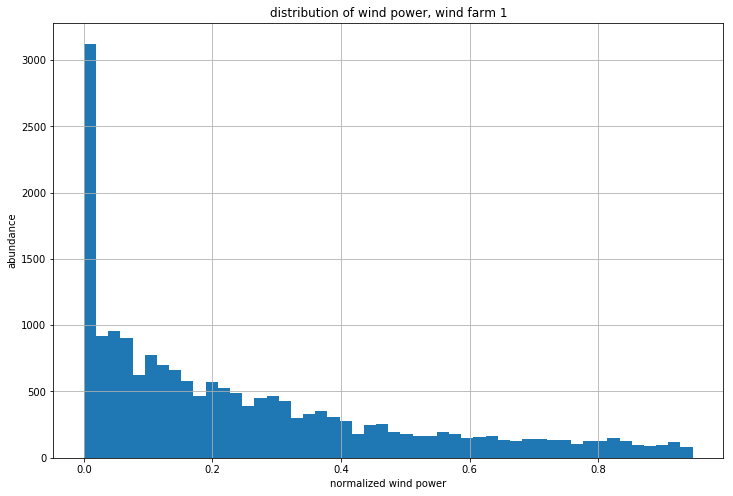

In [5]:
#wind power distribution; most of the time power outcome close to zero
fig, ax = plt.subplots(figsize=(12,8))
labels.loc['wf1'].hist(bins=50,ax = ax)
ax.set(title='distribution of wind power, wind farm 1', xlabel = 'normalized wind power', ylabel = 'abundance')
plt.show()

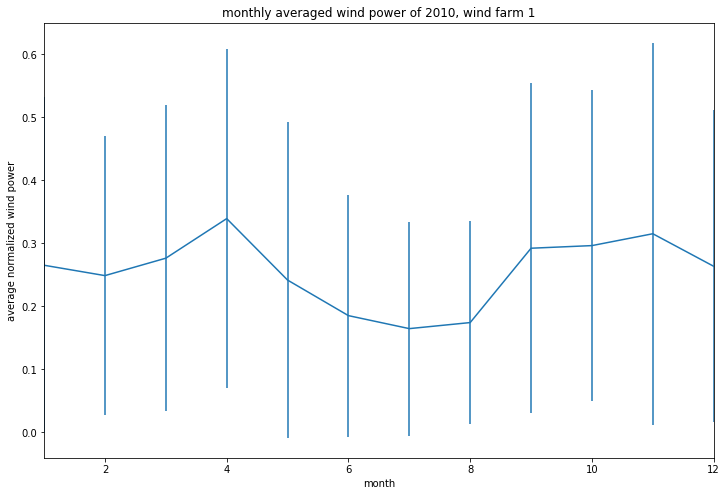

In [6]:
#monthly average of the wind power 
#low power outcome in the summer
#high volatility (see above) -> high variance
df_plot = labels.loc[labels['date'].dt.year==2010].loc['wf1'].groupby(labels['date'].loc['wf1'].dt.month)
fig, ax = plt.subplots(figsize=(12,8))
df_plot.mean().reset_index().plot(yerr=df_plot.std(),y='wp',x='date',ax = ax)
ax.set(title='monthly averaged wind power of 2010, wind farm 1', ylabel = 'average normalized wind power', xlabel = 'month')
ax.legend().set_visible(False)
plt.show()

In [7]:
from process_GEF2012 import train_test_split_seq
from process_GEF2012 import comb_pipeline

#all fcts for this cell in process_GEF2012.ipynb
#select attributes to train on; don't use u and v as they are redundant (e.g. u^2+w^2 = ws^2)
train_set, test_set = train_test_split_seq(data_labels_set, test_size = 0.1)

train_data = train_set.reset_index().loc(axis=1)[['wf','ws','wsm1','wsp1','wd','dow','dom','moy','hod','td_ip']]
train_labels = train_set.reset_index().loc(axis=1)[['wp']]
#final processing: convert to nparray, encode and impute data
train_data_prep = comb_pipeline.fit_transform(train_data)


/home/maxbjjansen/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2885: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


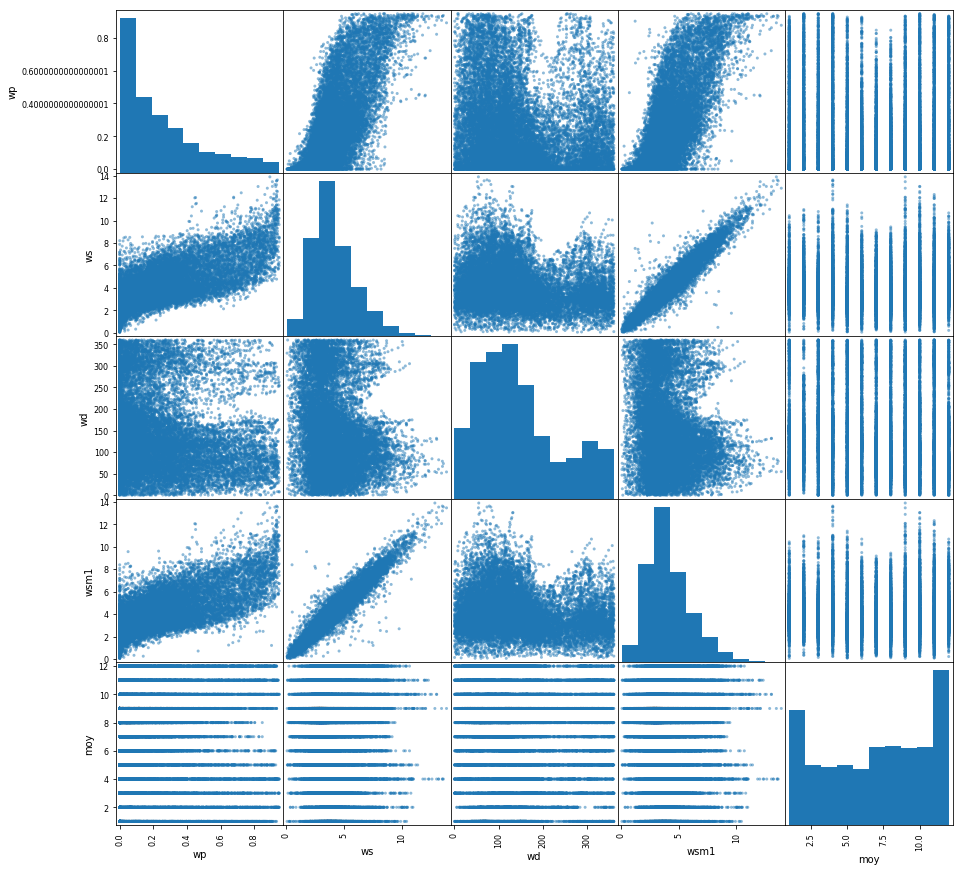

In [8]:
#check for correlations
#strong correlation for wp and ws;
#p peaks for ws = 100 and 300 (diff ca 180)
from matplotlib.ticker import FormatStrFormatter

df_plot = train_set.loc['wf1'].loc(axis=1)[['wp','ws','wd','wsm1','moy']]
fig, ax = plt.subplots(figsize=(15,15))
pd.plotting.scatter_matrix(df_plot, ax = ax)
ax.set(title='correlations between attributes and labels, wind farm 1')
plt.show()

In [9]:
#'standard' machine learning algorithms

In [10]:
#train a linear regressor
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()

lin_reg.fit(train_data_prep, train_labels.values)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [11]:
#train a decision tree regressor
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor(max_depth=30, min_samples_leaf=2)
tree_reg.fit(train_data_prep, train_labels.values)

DecisionTreeRegressor(criterion='mse', max_depth=30, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=2,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [12]:
#train a random forest regressor
from sklearn.ensemble import RandomForestRegressor
rnf_reg = RandomForestRegressor(n_estimators=100, max_leaf_nodes=100, n_jobs=-1)
rnf_reg.fit(train_data_prep, train_labels.values.ravel())

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=100,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [13]:
#compare the root mean squared error of the different methods
#tree regressor is overfitting
from sklearn.metrics import mean_squared_error

labels_lin_pred = lin_reg.predict(train_data_prep)

lin_reg_rmse = np.sqrt(mean_squared_error(train_labels, labels_lin_pred))
print("lin_rmse = ",lin_reg_rmse)


labels_tree_reg_pred = tree_reg.predict(train_data_prep)

tree_reg_rmse = np.sqrt(mean_squared_error(train_labels, labels_tree_reg_pred))
print("tree_reg_rmse = ",tree_reg_rmse)


labels_rnf_reg_pred = rnf_reg.predict(train_data_prep)

rnf_reg_rmse = np.sqrt(mean_squared_error(train_labels, labels_rnf_reg_pred))
print("rnf_reg_rmse = ",rnf_reg_rmse)

lin_rmse =  0.1668180114650852
tree_reg_rmse =  0.05775157623548956
rnf_reg_rmse =  0.1564140386890287


In [14]:
#more sophisticated evaluation using cross validation
from sklearn.model_selection import cross_validate
score_lin_reg = cross_validate(estimator = lin_reg, X = train_data_prep, y = train_labels, cv = 5, scoring = 'neg_mean_squared_error', return_train_score = True)

In [15]:
score_tree_reg = cross_validate(estimator = tree_reg, X = train_data_prep, y = train_labels, cv = 5, scoring = 'neg_mean_squared_error', return_train_score = True)

In [16]:
score_rnf_reg = cross_validate(estimator = rnf_reg, X = train_data_prep, y = train_labels.values.ravel(), cv = 5, scoring = 'neg_mean_squared_error', return_train_score = True)

In [17]:
#best results for the random forest regressor; the decision tree overfits
print('lin_reg test score:', np.sqrt(-score_lin_reg['test_score']))
print('lin_reg train score:', np.sqrt(-score_lin_reg['train_score']))
print('tree_reg test score:', np.sqrt(-score_tree_reg['test_score']))
print('tree_reg train score:', np.sqrt(-score_tree_reg['train_score']))
print('rnf_reg test score:', np.sqrt(-score_rnf_reg['test_score']))
print('rnf_reg train score:', np.sqrt(-score_rnf_reg['train_score']))

lin_reg test score: [0.16819851 0.1805794  0.1687016  0.17537969 0.17169665]
lin_reg train score: [0.16724533 0.16491782 0.16679716 0.16506425 0.16833169]
tree_reg test score: [0.20782048 0.22321214 0.20138848 0.2000057  0.21342533]
tree_reg train score: [0.05718885 0.05445568 0.05622812 0.05685452 0.05865698]
rnf_reg test score: [0.17645423 0.16984349 0.16253773 0.16618505 0.17099754]
rnf_reg train score: [0.15266497 0.15427719 0.15551193 0.1549945  0.15673673]


In [18]:
#optimize parameters using a randomized search for the random forest regressor
from sklearn.model_selection import RandomizedSearchCV
#random forest regressor without any set parameters
rnf_reg_search = RandomForestRegressor(n_jobs=-1)
param_dist_rnf_reg = {'n_estimators': [50,100,150], 
                      'max_leaf_nodes': [50,100,200],
                      'max_depth': [10,20,30],
                      'min_samples_leaf': [1,2,5,10],
                      'min_samples_split': [2,5,10]}
rand_search_rnf_reg = RandomizedSearchCV(rnf_reg_search, 
                                         param_distributions=param_dist_rnf_reg,
                                         n_iter = 20, 
                                         cv=5, 
                                         scoring='neg_mean_squared_error', 
                                         return_train_score=True)
rand_search_rnf_reg.fit(train_data_prep, train_labels.values.ravel())

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=20, n_jobs=None,
          param_distributions={'min_samples_leaf': [1, 2, 5, 10], 'n_estimators': [50, 100, 150], 'min_samples_split': [2, 5, 10], 'max_depth': [10, 20, 30], 'max_leaf_nodes': [50, 100, 200]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='neg_mean_squared_error',
          verbose=0)

In [19]:
#best parameters
rand_search_rnf_reg.best_params_

{'max_depth': 20,
 'max_leaf_nodes': 200,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 150}

In [20]:
#mean scores for different parameters
cvres=rand_search_rnf_reg.cv_results_
for mean_score, params in zip(cvres['mean_test_score'],cvres['params']):
    print(np.sqrt(-mean_score), params)

0.1693999557575593 {'max_depth': 10, 'n_estimators': 50, 'max_leaf_nodes': 100, 'min_samples_leaf': 1, 'min_samples_split': 5}
0.1693091763676035 {'max_depth': 10, 'n_estimators': 100, 'max_leaf_nodes': 100, 'min_samples_leaf': 1, 'min_samples_split': 2}
0.16684032706225888 {'max_depth': 20, 'n_estimators': 150, 'max_leaf_nodes': 200, 'min_samples_leaf': 2, 'min_samples_split': 10}
0.1713908553987247 {'max_depth': 20, 'n_estimators': 150, 'max_leaf_nodes': 50, 'min_samples_leaf': 1, 'min_samples_split': 2}
0.16936751779471843 {'max_depth': 10, 'n_estimators': 50, 'max_leaf_nodes': 100, 'min_samples_leaf': 5, 'min_samples_split': 10}
0.16743044792891584 {'max_depth': 10, 'n_estimators': 150, 'max_leaf_nodes': 200, 'min_samples_leaf': 1, 'min_samples_split': 5}
0.1669301904783034 {'max_depth': 20, 'n_estimators': 150, 'max_leaf_nodes': 200, 'min_samples_leaf': 2, 'min_samples_split': 5}
0.17155325668554747 {'max_depth': 20, 'n_estimators': 50, 'max_leaf_nodes': 50, 'min_samples_leaf': 5,

In [21]:
#the best random forest regressor for further use
best_rnf_reg=rand_search_rnf_reg.best_estimator_

In [22]:
#calculate root mean square for the best found rnf
labels_best_rnf_reg_pred = best_rnf_reg.predict(train_data_prep)

best_rnf_reg_rmse = np.sqrt(mean_squared_error(train_labels, labels_best_rnf_reg_pred))
print("best_rnf_reg_rmse = ",best_rnf_reg_rmse)

best_rnf_reg_rmse =  0.15010228740279571


/home/maxbjjansen/.local/lib/python3.5/site-packages/pandas/core/computation/check.py:19: UserWarning: The installed version of numexpr 2.5 is not supported in pandas and will be not be used
The minimum supported version is 2.6.1

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


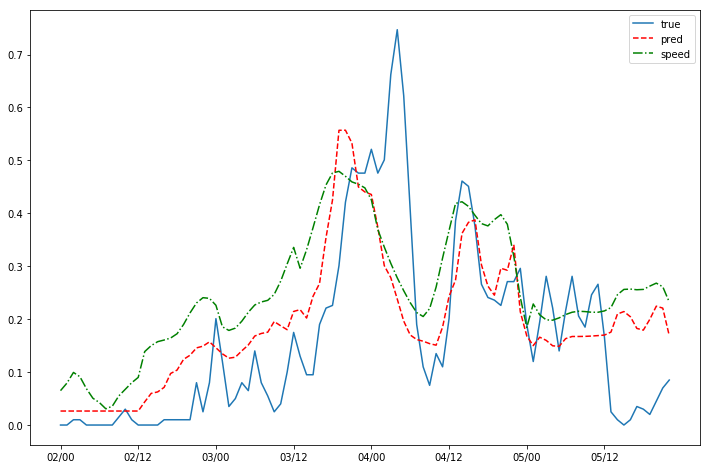

In [23]:
#plot the ground truth, the predicted wind power using the best rnf and the wind speed
#use 4 days
pltr1=data_labels_set.index.get_loc(('wf1','2009-07-02 00:00:00'))
pltr2=data_labels_set.index.get_loc(('wf1','2009-07-05 23:00:00'))
pltrange=range(pltr1,pltr2)

pred_labels=best_rnf_reg.predict(train_data_prep[pltrange])

true_labels=train_labels.iloc[pltrange].loc(axis=1)['wp'].values

wind_speed=train_data.iloc[pltrange].loc(axis=1)['ws']/max(train_data.loc(axis=1)['ws'])

dates_for_pred=data_labels_set.reset_index().loc(axis=1)['date'].iloc[pltrange].dt.strftime('%d/%H').values


plt.figure(figsize=(12,8))
plt.plot(dates_for_pred,true_labels,label='true',linestyle='-')
plt.plot(dates_for_pred,pred_labels,label='pred',linestyle='--',color='red')
plt.plot(dates_for_pred,wind_speed,label='speed',linestyle='-.',color='green')
plt.xticks(dates_for_pred[0::12])
plt.legend()
plt.show()

In [24]:
#neural network

In [25]:
from NN_Regression import NNRegressor

Using TensorFlow backend.


In [26]:
#checkpoint the neural network
#if checkpoint file exists, the model will NOT use the passed, model-related values below 
#i.e. drop_rate, max_units, activation_fct, lr, decay_rate
#but the values of the loaded model
#for cross validation, the model must not be checkpointed and the validation_split should be omitted

ckpt_path = "nn_model/cp-best_model.h5"

NN_reg = NNRegressor(drop_rate = 0.2, 
                 max_units = 64, 
                 activation_fct = 'relu',
                 lr = 0.001, 
                 decay_rate = 1e-5, 
                 epochs = 10,
                 batch_size = 128,
                 period = 5,
                 validation_split = 0.1,
                 ckpt_path = ckpt_path,
                 verbose = 0)


In [27]:
NN_reg.fit(train_data_prep,train_labels.values)

NNRegressor(activation_fct='relu', batch_size=128,
      ckpt_path='nn_model/cp-best_model.h5', decay_rate=1e-05,
      drop_rate=0.2, epochs=10, lr=0.001, max_units=64, period=5,
      validation_split=0.1, verbose=0)

In [28]:
from sklearn.metrics import mean_squared_error
labels_NN_reg_pred = NN_reg.predict(train_data_prep)

NN_reg_rmse = np.sqrt(mean_squared_error(train_labels, labels_NN_reg_pred))
print("NN_reg_rmse = ",NN_reg_rmse)

NN_reg_rmse =  0.13758919881170933


In [29]:
#more sophisticated evaluation using cross validation
from sklearn.model_selection import cross_validate
score_NN_reg = cross_validate(estimator = NN_reg, 
                              X = train_data_prep.toarray(), 
                              y = train_labels.values, 
                              cv = 5, 
                              scoring = 'neg_mean_squared_error', 
                              return_train_score = True)

In [30]:
#slight overfitting of the network
print('NN_reg test score:', np.sqrt(-score_NN_reg['test_score']))
print('NN_reg train score:', np.sqrt(-score_NN_reg['train_score']))

NN_reg test score: [0.13948315 0.14047762 0.14016342 0.14680302 0.14324383]
NN_reg train score: [0.13893539 0.13369512 0.13473103 0.13820259 0.13460037]


In [31]:
#optimize parameters using a randomized search for the neural network regressor
from sklearn.model_selection import RandomizedSearchCV
NN_reg_search = NNRegressor(
                 decay_rate = 1e-5, 
                 epochs = 10,
                 batch_size = 128,
                 validation_split = 0.0,
                 ckpt_path = None,
                 verbose = 0)

param_dist_NN_reg = {'drop_rate': [0.1,0.2], 
                      'max_units': [32,64],
                      'activation_fct': ['relu', 'sigmoid'],
                      'lr': [0.001,0.002]}
rand_search_NN_reg = RandomizedSearchCV(NN_reg_search, 
                                         param_distributions=param_dist_NN_reg,
                                         n_iter = 10, 
                                         cv=5, 
                                         scoring='neg_mean_squared_error', 
                                         return_train_score=True)#,
                                         #n_jobs=-1)
rand_search_NN_reg.fit(train_data_prep.toarray(), train_labels.values.ravel())

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=NNRegressor(activation_fct='relu', batch_size=128, ckpt_path=None,
      decay_rate=1e-05, drop_rate=0.2, epochs=10, lr=0.001, max_units=64,
      period=5, validation_split=0.0, verbose=0),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'max_units': [32, 64], 'lr': [0.001, 0.002], 'drop_rate': [0.1, 0.2], 'activation_fct': ['relu', 'sigmoid']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='neg_mean_squared_error',
          verbose=0)

In [32]:
#best parameters
rand_search_NN_reg.best_params_

{'activation_fct': 'sigmoid', 'drop_rate': 0.1, 'lr': 0.002, 'max_units': 64}

In [33]:
#the best NN regressor for further use
best_NN_reg=rand_search_NN_reg.best_estimator_

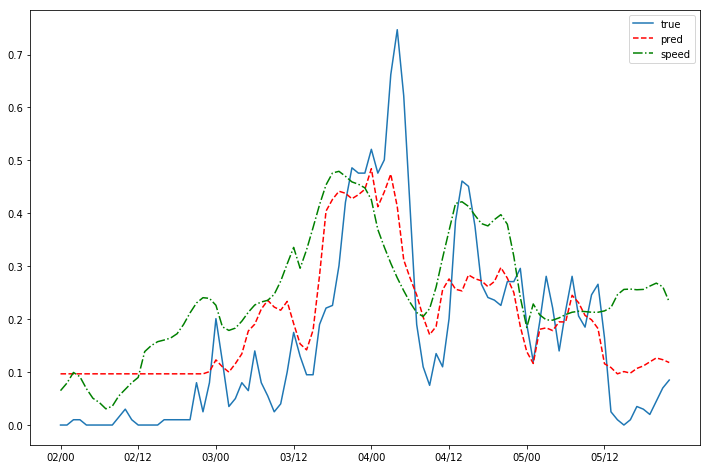

In [37]:
#plot the ground truth, the predicted wind power using the best NN and the wind speed
#use 4 days
pltr1=data_labels_set.index.get_loc(('wf1','2009-07-02 00:00:00'))
pltr2=data_labels_set.index.get_loc(('wf1','2009-07-05 23:00:00'))
pltrange=range(pltr1,pltr2)

pred_labels=best_NN_reg.predict(train_data_prep[pltrange])

true_labels=train_labels.iloc[pltrange].loc(axis=1)['wp'].values

wind_speed=train_data.iloc[pltrange].loc(axis=1)['ws']/max(train_data.loc(axis=1)['ws'])

dates_for_pred=data_labels_set.reset_index().loc(axis=1)['date'].iloc[pltrange].dt.strftime('%d/%H').values


plt.figure(figsize=(12,8))
plt.plot(dates_for_pred,true_labels,label='true',linestyle='-')
plt.plot(dates_for_pred,pred_labels,label='pred',linestyle='--',color='red')
plt.plot(dates_for_pred,wind_speed,label='speed',linestyle='-.',color='green')
plt.xticks(dates_for_pred[0::12])
plt.legend()
plt.show()

In [35]:
#outlook: ensemble methods